In [41]:
%load_ext autoreload
%autoreload 2

# Pagel's lambda for growth rates
import os 
from src.ihmp import get_diffs, pagels_dataframe

# Global variables
GG_TREE = "./greengenes/data/gg_13_5_otus_99_annotated.tree"
TOP_N = 10
ABUNDANCE = True

# Datasets
names = ["ibd", "moms", "t2d"]

# Some string stuff
if ABUNDANCE:
    ab_str = "abun_"
    ab_title = "Relative abundances"
else:
    ab_str = ""
    ab_title = "$\delta$ log-relative abundances"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Distill into iHMP-agnostic function:
data = {
    name: get_diffs(name, top_n=TOP_N, get_abundances=ABUNDANCE)
    for name in names
}


In [43]:
# Compute lambda values for each iHMP dataset:

for name in names:
    outpath = f"./results/{name}_{ab_str}pls_top{TOP_N}.tsv"
    if os.path.exists(outpath):
        print(f"Skipping {outpath} because it already exists.")
        continue
    pls, tree = pagels_dataframe(data[name], GG_TREE)
    pls.to_csv(outpath, sep="\t")
    tree.write(
        format=1, outfile=f"./results/{name}_{ab_str}tree_top{TOP_N}.nwk"
    )


  1%|          | 73/9170 [00:00<00:25, 363.86it/s]/home/phil/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 14%|█▍        | 318/2304 [00:01<00:06, 311.13it/s]/home/phil/miniconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
100%|██████████| 2304/2304 [00:07<00:00, 291.84it/s]


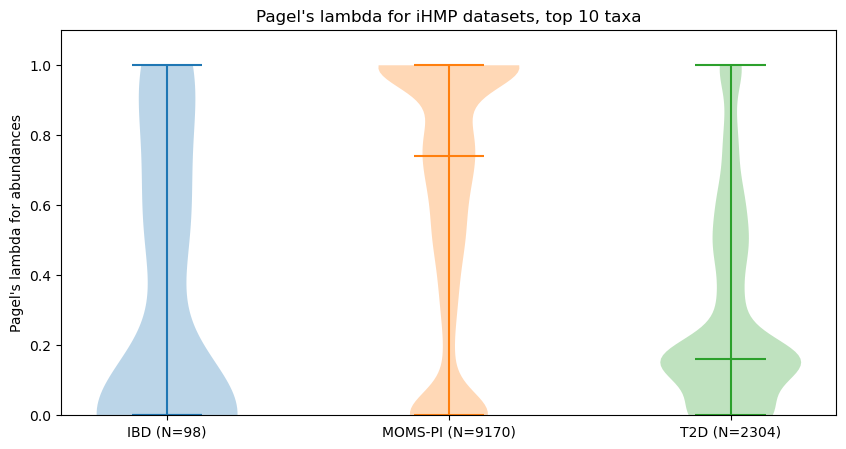

In [44]:
# Violin plot
import matplotlib.pyplot as plt
import pandas as pd

data = []
for name in names:
    pls = pd.read_table(f"./results/{name}_{ab_str}pls_top{TOP_N}.tsv")
    pls["dataset"] = name.upper()
    data.append(pls)

pls = pd.concat(data)

# Plot
plt.figure(figsize=(10, 5))
datasets = pls["dataset"].unique()
for i, dataset in enumerate(data):
    plt.violinplot(
        dataset["lambda"].dropna().values,
        showmedians=True,
        positions=[i + 1],
    )

# print(len(ibd_pls["lambda"].dropna().values)) # 69
# print(len(moms_pls["lambda"].dropna().values)) # 6765
# print(len(t2d_pls["lambda"].dropna().values)) # 2071

if ABUNDANCE:
    plt.ylabel("Pagel's $\lambda$ for abundances")
    plt.xticks(range(1, 4), ["IBD (N=98)", "MOMS-PI (N=9170)", "T2D (N=2304)"])
else:
    plt.ylabel("Pagel's $\lambda$ for growth rates")
    plt.xticks(range(1, 4), ["IBD (N=69)", "MOMS-PI (N=6765)", "T2D (N=2071)"])
plt.title(f"Pagel's $\lambda$ for iHMP datasets, top {TOP_N} taxa\n{ab_title}")
plt.ylim(0, 1.1)
plt.savefig(f"./results/{ab_str}pls_top{TOP_N}.png", dpi=300)
plt.show()

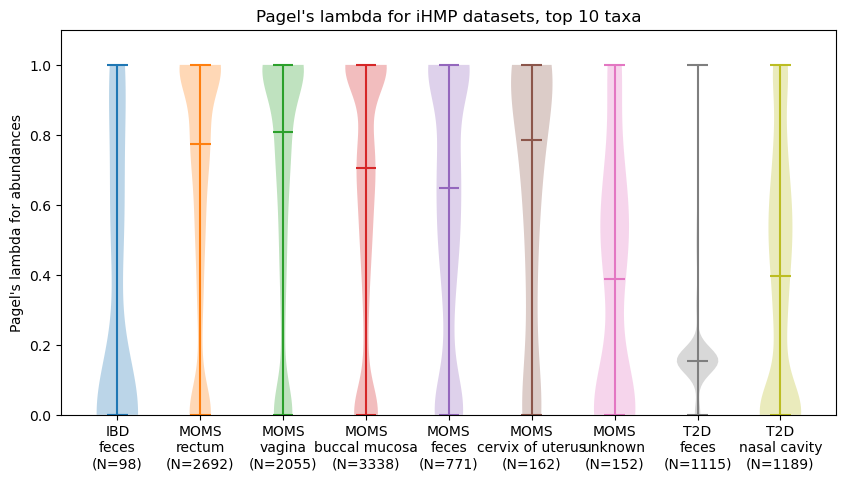

In [45]:
# Same thing but grouped by body site

# Only need the plotting part, though:
plt.figure(figsize=(10, 5))
datasets = pls["dataset"].unique()
labels = []
position = 1
for dataset in data:
    for site in dataset["site"].unique():
        name = dataset["dataset"].unique()[0]
        lambdas = dataset[dataset["site"] == site]["lambda"].dropna().values
        if len(lambdas) > 4: # Drop uselessly small samples
            labels.append(f"{name}\n{site}\n(N={len(lambdas)})")
            plt.violinplot(lambdas, showmedians=True, positions=[position])
            position += 1

plt.xticks(range(1, position), labels)
if ABUNDANCE:
    plt.ylabel("Pagel's $\lambda$ for abundances")
else:
    plt.ylabel("Pagel's $\lambda$ for growth rates")
plt.title(f"Pagel's $\lambda$ for iHMP datasets, top {TOP_N} taxa\n{ab_title}")
plt.ylim(0, 1.1)
plt.savefig(f"./results/{ab_str}lambda_by_site_top{TOP_N}.png", dpi=300)
plt.show()

In [46]:
# New experiment: effect of top_N on lambda values, violin plot, IBD only

topn_vals = [10, 20, 50, 100, 200, 500, 1000]#, None]

for top_n in topn_vals:
    # We already did 100 and 1000, so we skip them for now
    outpath = f"./results/ibd_{ab_str}pls_top{top_n}.tsv"
    if os.path.exists(outpath):
        continue
    
    print(f"top_n={top_n}")
    diffs_ibd = get_diffs("ibd", top_n=top_n, get_abundances=ABUNDANCE)
    pls, tree = pagels_dataframe(diffs_ibd, GG_TREE)
    pls.to_csv(outpath)
    tree.write(format=1, outfile=f"./results/ibd_{ab_str}tree_top{top_n}.nwk")

top_n=20


100%|██████████| 98/98 [00:00<00:00, 252.06it/s]


top_n=50


100%|██████████| 98/98 [00:05<00:00, 18.52it/s]


top_n=200


100%|██████████| 98/98 [01:02<00:00,  1.58it/s]


top_n=500


 45%|████▍     | 44/98 [02:36<03:21,  3.72s/it]

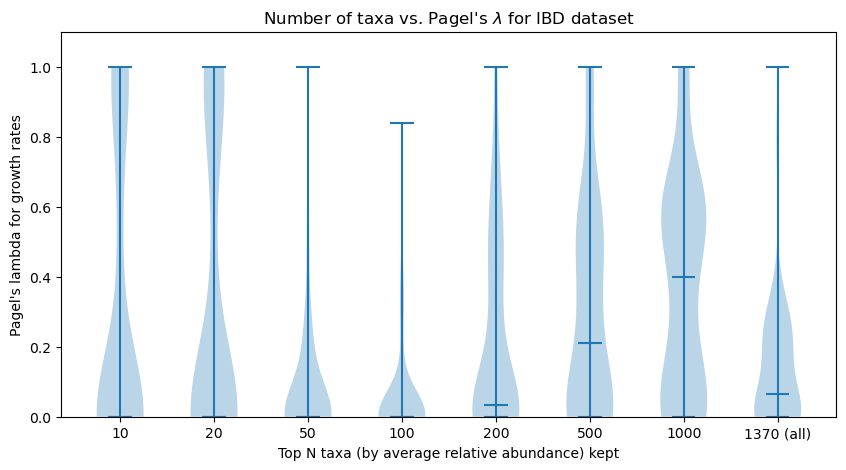

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = []
for top_n in topn_vals:
    pls = pd.read_table(f"./results/ibd_{ab_str}pls_top{top_n}.tsv")
    pls["top_n"] = top_n
    data.append(pls)

pls = pd.concat(data)

# Plot
plt.figure(figsize=(10, 5))
# for i, top_n in enumerate(pls["top_n"].unique()):
plt.violinplot(
    [x["lambda"].values for x in data],
    showmedians=True,
    # positions=[i + 1],
)

# plt.xticks(range(1, len(topn_vals) + 1), topn_vals[:-1] + ["1370 (all)"])
plt.xticks(range(1, len(topn_vals) + 1), topn_vals)
plt.xlabel("Top N taxa (by average relative abundance) kept")
plt.ylabel("Pagel's $\lambda$ for growth rates")
plt.title(f"Number of taxa vs. Pagel's $\lambda$ for IBD dataset\n{ab_title}")
plt.ylim(0, 1.1)
plt.savefig(f"./results/{ab_str}pls_top_n.png", dpi=300)
plt.show()